A part of code is from

Yasin, M. (2024). Retrieving Object-Level Features From YOLO. Yasin's Keep. https://y-t-g.github.io/tutorials/yolo-object-features/

(It is explicitly stated in the related parts too)


# Packages

In [8]:
!git clone https://github.com/ultralytics/ultralytics

Cloning into 'ultralytics'...
remote: Enumerating objects: 62287, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 62287 (delta 29), reused 25 (delta 10), pack-reused 62221 (from 2)
Receiving objects: 100% (62287/62287), 33.16 MiB | 12.34 MiB/s, done.
Resolving deltas: 100% (46448/46448), done.


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
%cd ultralytics

/content/ultralytics


In [11]:
!pip install -e .

Obtaining file:///content/ultralytics
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [12]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 17.6 MB/s eta 0:00:00


In [13]:
!pip install iterative-stratification
!pip install shapely
!pip install xgboost
!pip install imblearn

In [14]:
import os
import random
import shutil
from pathlib import Path
from math import gcd
from glob import glob
from collections import Counter
from types import MethodType
import numpy as np
import pandas as pd
import yaml
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from shapely.geometry import Polygon
from shapely.geometry import Polygon, box as shapely_box
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, KFold
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    balanced_accuracy_score, roc_auc_score, log_loss,
    f1_score, make_scorer
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.pipeline import Pipeline
import xgboost as xgb
from xgboost import XGBClassifier
import optuna
from optuna import Trial
from optuna.visualization import plot_optimization_history, plot_param_importances
from optuna.visualization import plot_intermediate_values
import torch
import torch.nn.functional as F
from torch.nn.functional import cosine_similarity
from ultralytics import YOLO, ASSETS
from ultralytics.utils.ops import xywh2xyxy, scale_boxes
from ultralytics.engine.results import Results
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import joblib
import time
import seaborn as sns
import shap


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# >>> **EXTRACTING EMBEDDINGS AND DATA**

# Functions

The following functions NMS & Predict-Once for embedding extraction:

Yasin, M. (2024). Retrieving Object-Level Features From YOLO. Yasin's Keep. https://y-t-g.github.io/tutorials/yolo-object-features/


## NMS

In [15]:
# Custom NMS to return the idxs of filtered boxes
def non_max_suppression(
    prediction,
    conf_thres=0.5, # like in YOLO pred
    iou_thres=0.5, # like in YOLO pred
    classes=None,
    agnostic=False,
    multi_label=False,
    labels=(),
    max_det=300,
    nc=2,  # number of classes in dataset
    max_time_img=0.05,
    max_nms=30000,
    max_wh=7680,
    in_place=True,
    rotated=False,
):
    """
    Perform non-maximum suppression (NMS) on a set of boxes, with support for masks and multiple labels per box.

    Args:
        prediction (torch.Tensor): A tensor of shape (batch_size, num_classes + 4 + num_masks, num_boxes)
            containing the predicted boxes, classes, and masks. The tensor should be in the format
            output by a model, such as YOLO.
        conf_thres (float): The confidence threshold below which boxes will be filtered out.
            Valid values are between 0.0 and 1.0.
        iou_thres (float): The IoU threshold below which boxes will be filtered out during NMS.
            Valid values are between 0.0 and 1.0.
        classes (List[int]): A list of class indices to consider. If None, all classes will be considered.
        agnostic (bool): If True, the model is agnostic to the number of classes, and all
            classes will be considered as one.
        multi_label (bool): If True, each box may have multiple labels.
        labels (List[List[Union[int, float, torch.Tensor]]]): A list of lists, where each inner
            list contains the apriori labels for a given image. The list should be in the format
            output by a dataloader, with each label being a tuple of (class_index, x1, y1, x2, y2).
        max_det (int): The maximum number of boxes to keep after NMS.
        nc (int, optional): The number of classes output by the model. Any indices after this will be considered masks.
        max_time_img (float): The maximum time (seconds) for processing one image.
        max_nms (int): The maximum number of boxes into torchvision.ops.nms().
        max_wh (int): The maximum box width and height in pixels.
        in_place (bool): If True, the input prediction tensor will be modified in place.
        rotated (bool): If Oriented Bounding Boxes (OBB) are being passed for NMS.

    Returns:
        (List[torch.Tensor]): A list of length batch_size, where each element is a tensor of
            shape (num_boxes, 6 + num_masks) containing the kept boxes, with columns
            (x1, y1, x2, y2, confidence, class, mask1, mask2, ...).
    """
    import torchvision  # scope for faster 'import ultralytics'

    # Checks
    assert 0 <= conf_thres <= 1, f"Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0"
    assert 0 <= iou_thres <= 1, f"Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0"
    if isinstance(prediction, (list, tuple)):  # YOLOv8 model in validation model, output = (inference_out, loss_out)
        prediction = prediction[0]  # select only inference output
    if classes is not None:
        classes = torch.tensor(classes, device=prediction.device)

    if prediction.shape[-1] == 6:  # end-to-end model (BNC, i.e. 1,300,6)
        output = [pred[pred[:, 4] > conf_thres][:max_det] for pred in prediction]
        if classes is not None:
            output = [pred[(pred[:, 5:6] == classes).any(1)] for pred in output]
        return output

    bs = prediction.shape[0]  # batch size (BCN, i.e. 1,84,6300)
    nc = nc or (prediction.shape[1] - 4)  # number of classes
    nm = prediction.shape[1] - nc - 4  # number of masks
    mi = 4 + nc  # mask start index
    xc = prediction[:, 4:mi].amax(1) > conf_thres  # candidates

    # To keep track of the prediction indices that remain at the end, we create an indices
    # list that will be applied the same filters that get applied to the original predictions.
    # That way, at the end, we will have xks with only the indices of the predictions that
    # have not been eliminated.
    xinds = torch.stack([torch.arange(len(i), device=prediction.device) for i in xc])[...,None]
    # Settings
    # min_wh = 2  # (pixels) minimum box width and height
    time_limit = 2.0 + max_time_img * bs  # seconds to quit after
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)

    prediction = prediction.transpose(-1, -2)  # shape(1,84,6300) to shape(1,6300,84)
    if not rotated:
        if in_place:
            prediction[..., :4] = xywh2xyxy(prediction[..., :4])  # xywh to xyxy
        else:
            prediction = torch.cat((xywh2xyxy(prediction[..., :4]), prediction[..., 4:]), dim=-1)  # xywh to xyxy

    t = time.time()
    output = [torch.zeros((0, 6 + nm), device=prediction.device)] * bs
    feati = [torch.zeros((0, 1), device=prediction.device)] * bs
    for xi, (x, xk) in enumerate(zip(prediction, xinds)):  # image index, image inference
        # Apply constraints
        # x[((x[:, 2:4] < min_wh) | (x[:, 2:4] > max_wh)).any(1), 4] = 0  # width-height
        filt = xc[xi]
        x = x[filt]  # confidence
        xk = xk[filt] # indices update

        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]) and not rotated:
            lb = labels[xi]
            v = torch.zeros((len(lb), nc + nm + 4), device=x.device)
            v[:, :4] = xywh2xyxy(lb[:, 1:5])  # box
            v[range(len(lb)), lb[:, 0].long() + 4] = 1.0  # cls
            x = torch.cat((x, v), 0)

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Detections matrix nx6 (xyxy, conf, cls)
        box, cls, mask = x.split((4, nc, nm), 1)

        if multi_label:
            i, j = torch.where(cls > conf_thres)
            x = torch.cat((box[i], x[i, 4 + j, None], j[:, None].float(), mask[i]), 1)
            xk = xk[i] # indices update
        else:  # best class only
            conf, j = cls.max(1, keepdim=True)
            filt = conf.view(-1) > conf_thres
            x = torch.cat((box, conf, j.float(), mask), 1)[filt]
            xk = xk[filt] # indices update

        # Filter by class
        if classes is not None:
            filt = (x[:, 5:6] == classes).any(1)
            x = x[filt]
            xk = xk[filt] # indices update

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        if n > max_nms:  # excess boxes
            filt = x[:, 4].argsort(descending=True)[:max_nms]
            x = x[filt]  # sort by confidence and remove excess boxes
            xk = xk[filt] # indices update

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        scores = x[:, 4]  # scores
        if rotated:
            boxes = torch.cat((x[:, :2] + c, x[:, 2:4], x[:, -1:]), dim=-1)  # xywhr
            i = nms_rotated(boxes, scores, iou_thres)
        else:
            boxes = x[:, :4] + c  # boxes (offset by class)
            i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        i = i[:max_det]  # limit detections

        # # Experimental
        # merge = False  # use merge-NMS
        # if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
        #     # Update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
        #     from .metrics import box_iou
        #     iou = box_iou(boxes[i], boxes) > iou_thres  # IoU matrix
        #     weights = iou * scores[None]  # box weights
        #     x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
        #     redundant = True  # require redundant detections
        #     if redundant:
        #         i = i[iou.sum(1) > 1]  # require redundancy

        output[xi] = x[i]
        # xk would contain the indices of the predictions that are in x,
        # i.e. you could index the `prediction` variable at the beginning of this function
        # and get the final x (in xyxy format)
        feati[xi] = xk[i].reshape(-1)
        if (time.time() - t) > time_limit:
            print(f"WARNING ⚠️ NMS time limit {time_limit:.3f}s exceeded")
            break  # time limit exceeded
    return output, feati

## Predict-Once

In [16]:
def _predict_once(self, x, profile=False, visualize=False, embed=None):
    y, dt, embeddings = [], [], []  # outputs
    for m in self.model:
        if m.f != -1:  # if not from previous layer
            x = y[m.f] if isinstance(m.f, int) else [x if j == -1 else y[j] for j in m.f]  # from earlier layers
        if profile:
            self._profile_one_layer(m, x, dt)
        x = m(x)  # run
        y.append(x if m.i in self.save else None)  # save output
        if visualize:
            feature_visualization(x, m.type, m.i, save_dir=visualize)

        # Change this so that it returns the feature maps without any change
        if embed and m.i in embed:
            embeddings.append(x)  # flatten
            if m.i == max(embed):
                return embeddings
    return x

In [17]:
def get_object_features(feat_list, idxs):
    s = gcd(*[x.shape[1] for x in feat_list])  # smallest vector length
    obj_feats = torch.cat([
        x.permute(0, 2, 3, 1).reshape(x.shape[0], -1, s, x.shape[1] // s).mean(dim=-1)
        for x in feat_list
    ], dim=1)

    # Cast idx to long/int
    return [feats[idx.long()] for feats, idx in zip(obj_feats, idxs)]

## Creating Data with Masks/Polygons

In [18]:
def mask_to_polygon(binary_mask): #Convert a binary mask to a polygon.
    if binary_mask.dtype != np.uint8:
        binary_mask = binary_mask.astype(np.uint8) #masks must be uint8

    if len(binary_mask.shape) != 2: #invalid (2D)
        return None

    if np.sum(binary_mask) == 0: #empty mask
        return None

    # Extract contour
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None

# To get useful contour (biggest so with enough points)
    largest_contour = max(contours, key=cv2.contourArea)
    coords = largest_contour.squeeze()

    if coords.ndim != 2 or coords.shape[0] < 3:
        return None

    return Polygon(coords)

In [19]:
def extract_features_from_polygon(polygon):
    minx, miny, maxx, maxy = polygon.bounds
    width = maxx - minx #width = wingspan
    height = maxy - miny #length
    area = polygon.area
    perimeter = polygon.length #total length of the polygon edges
    hull_area = polygon.convex_hull.area #to measure shape irregularity
    compactness = (perimeter ** 2) / (4 * np.pi * area) if area > 0 else 0 #compactness = ex: circle no compact, while long-weird shapes biggest compact. Military can be less compact because civil are more regular

# Convert to meters

    gsd = 0.3 #Because of Maxar WorldView-3 satellite images
    width_m = width*gsd
    height_m = height*gsd
    area_m = area*(gsd**2) #square meters
    perimeter_m = perimeter*gsd
    hull_area_m = hull_area*gsd
    compactness = compactness*gsd #uniteless
    if width_m <= 15:
        wingspan_class = "A"
    elif width_m <= 24:
        wingspan_class = "B"
    elif width_m <= 36:
        wingspan_class = "C"
    elif width_m <= 52:
        wingspan_class = "D"
    elif width_m <= 65:
        wingspan_class = "E"
    elif width_m <= 80:
        wingspan_class = "F"
    else:
        wingspan_class = "Unknown"

    return [width_m, height_m, area_m, perimeter_m, hull_area_m,compactness, wingspan_class]

## Extract_image_data

The whole function to get all

In [20]:
def extract_image_data(model, img_path):
    img = cv2.imread(img_path)
    prepped = model.predictor.preprocess([img])
    result = model.predictor.inference(prepped) # run inference

    nc = model.model.yaml['nc'] #nms
    output, idxs = non_max_suppression(result[-1][0], nc=nc, in_place=False)

    obj_feats = get_object_features(result[:3], idxs) #retrieve embeddings

    # bbox rescaling to original
    output[0][:, :4] = scale_boxes(prepped.shape[2:], output[0][:, :4], img.shape)

    # Extract masks (try to fix the error here)
    masks = None
    try:
        masks_candidate = result[-1][1]
        if isinstance(masks_candidate, tuple): #output structure
            masks = masks_candidate[0]
        else:
            masks = masks_candidate

    except (IndexError, AttributeError) as e:
        masks = None

    # image name
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    image_rows = []

    # collect from each iteration
    for i, det in enumerate(output[0]):
        x1, y1, x2, y2, conf, cls = det[:6].tolist() #bbox + conf + cls
        embedding = obj_feats[0][i].cpu().numpy()

        poly = None

        if masks is not None:
            if isinstance(masks, torch.Tensor):
                current_masks = masks[0]
            elif isinstance(masks, list):
                current_masks = masks[0]
            elif isinstance(masks, tuple):
                current_masks = masks[0]
            else:
                current_masks = None

            if current_masks is not None and i < len(current_masks):
                soft_mask = current_masks[i]
                binary_mask = (soft_mask > 0.5).cpu().numpy().astype(np.uint8) #binarize and convert to polygon
                poly = mask_to_polygon(binary_mask)

        if poly is None: #If cannot converted, go for polygon
            poly = shapely_box(x1, y1, x2, y2)

        features = extract_features_from_polygon(poly)

        row = {
            "image": f"{base_name}_{i+1}",
            "class": int(cls),
            "confidence": float(conf),
            "embedding": embedding,
            "features": features
        }
        image_rows.append(row)

    return image_rows


# >>> **TRAIN XGB**

The first, dataframe_train, creates the datasets for each scenario. The second, train_and_tune_xgb, applies training and tuning stages to all models in all scenarios. The third, evaluate_and_save_model, shows each model's and scenario's evaluation results. Then, it saves all of these models for use in the testing phase.

In [ ]:
pt_yolo = "/content/drive/MyDrive/final_train/weights/best.pt" # Best YOLO (Model3/Pre-trained YOLO11m-seg)
train_set_csv = "/content/drive/MyDrive/YOLO_roboflow_/train/gt_train.csv" # To use as y-test of XGB

## dataframe_train Function

The goal is to create datasets to train XGBoost from the original training set by using best YOLO

In [ ]:
  model = YOLO(yolo_model)

In [ ]:
def dataframe_train(yolo_model, train_set_csv, data_type):
  model = YOLO(yolo_model)

  model.model._predict_once = MethodType(_predict_once, model.model) # Adjusted new function

  _ = model("/content/drive/MyDrive/YOLO_roboflow_/train/images/100_1040010029990A00_tile_1.png", save=False, embed=[16, 19, 22, 23]) # Layers were choosen by looking the model details

  imgs = [cv2.imread("/content/drive/MyDrive/YOLO_roboflow_/train/images/100_1040010029990A00_tile_1.png")]
  prepped = model.predictor.preprocess(imgs)
  result = model.predictor.inference(prepped)

  nc = model.model.yaml['nc']
  output, idxs = non_max_suppression(result[-1][0], nc=nc, in_place=False)

  obj_feats = get_object_features(result[:3], idxs)

  image_i = 0  #index of the image in batch
  output[image_i][:, :4] = scale_boxes(prepped.shape[2:], output[image_i][:, :4], imgs[image_i].shape)
  result = Results(imgs[image_i], path="", names=model.predictor.model.names, boxes=output[image_i][:, :6])
  plt.imshow(result.plot()[..., ::-1])

  # All data to create the df
  image_paths = sorted(glob("/content/drive/MyDrive/YOLO_roboflow_/train/images/*.png"))

  all_rows = []
  for img_path in image_paths:
      image_data = extract_image_data(model, img_path)
      all_rows.extend(image_data)

  # Flatten data
  flat_rows = []
  for row in all_rows:
      flat_row = {
          "image": row["image"],
          "class": row["class"], # YOLO preds' classes
          "confidence": row["confidence"], # Conf level for each pred
      }
      flat_row.update({f"emb_{i}": val for i, val in enumerate(row["embedding"])})
      flat_row.update({f"meta_{i}": val for i, val in enumerate(row["features"])})
      flat_rows.append(flat_row)

  xgb_data_train = pd.DataFrame(flat_rows)

  xgb_data_train.rename(columns={
    "meta_0": "width_m",
    "meta_1": "height_m",
    "meta_2": "area_m",
    "meta_3": "perimeter_m",
    "meta_4": "hull_area_m",
    "meta_5": "compactness_m",
    "meta_6": "wingspan_class",
}, inplace=True)

  # Label encoding
  labels = ["A", "B", "C", "D", "E", "F"]
  le = LabelEncoder()
  encoded = le.fit_transform(labels)
  joblib.dump(le, "label_encoder.pkl") # Encoder SAVE for test
  xgb_data_train['wingspan_class'] = LabelEncoder().fit_transform(xgb_data_train['wingspan_class'])
  yolo_preds = xgb_data_train["class"]
  yolo_preds = yolo_preds.to_csv("yolo_preds.csv", index=False)

  y_train = pd.read_csv(train_set_csv)

  # To add YOLO's extra predictions and the ones which it couldn't see
  xgb_data_train = pd.merge(xgb_data_train, y_train, on='image', how='outer')
  xgb_data_train['class_id'] = xgb_data_train['class_id'].fillna(2).astype(int)
  xgb_data_train.to_csv("xgb_data_train_1.csv", index=False)
  y_train_df =  xgb_data_train['class_id']
  y_train =  xgb_data_train['class_id'].values
  y_train_df.to_csv("y_train.csv", index=False)

  # Drop the unnecessary columns of YOLO
  xgb_data_train = xgb_data_train.drop(columns=["class", "image", "class_id"])
  # Standardization
  columns_to_scale = xgb_data_train.columns[0:263]
  scaler = StandardScaler()
  xgb_data_train[columns_to_scale] = scaler.fit_transform(xgb_data_train[columns_to_scale])
  joblib.dump(scaler, "scaler.pkl") # Scaler SAVE
  xgb_data_train.to_csv("xgb_data_train.csv", index=False)

  if data_type == "full":
    X_train = xgb_data_train.values
  elif data_type == "embeddings": #Embedding
    embeddings_df = xgb_data_train.drop(xgb_data_train.columns[257:264], axis=1)
    embeddings_df.to_csv("embeddings.csv", index=False)
    X_train = embeddings_df.values
  elif data_type == "metadata": #Geo Data
    selected_columns = list(xgb_data_train.columns[257:264]) + [xgb_data_train.columns[0]]
    metadata_df = xgb_data_train[selected_columns]
    metadata_df.to_csv("metadata.csv", index=False)
    X_train = metadata_df.values
  else:
    print('error')

  return X_train, y_train, yolo_preds


## EDA - To see everything including labels (class_id)

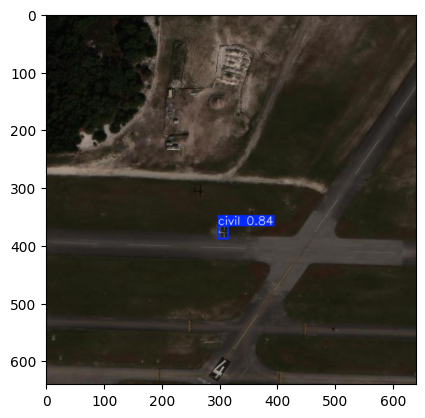

In [ ]:
X_all, y_all, yolo_preds = dataframe_train(pt_yolo, train_set_csv, "full")

In [ ]:
dataframe_t = pd.read_csv("/content/ultralytics/xgb_data_train_1.csv") # Before standardization or dropping anything etc.

In [ ]:
dataframe_t.head(3)

,image,class,confidence,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,...,emb_254,emb_255,width_m,height_m,area_m,perimeter_m,hull_area_m,compactness_m,wingspan_class,class_id
0,100_1040010029990A00_tile_1_1,0.0,0.906467,-0.121409,0.231050,-0.250314,-0.216927,0.235811,0.023802,-0.095912,...,2.256864,-0.217743,24.599991,18.509276,455.328016,86.218533,1517.760052,0.389752,2.0,0
1,100_1040010029990A00_tile_1_2,0.0,0.894299,-0.137559,1.445656,0.471489,-0.252122,-0.089164,-0.261611,-0.148325,...,-0.092997,-0.100576,20.574454,17.066748,351.139018,75.282404,1170.463394,0.385318,1.0,0
2,100_1040010029990A00_tile_1_3,0.0,0.865616,-0.215649,0.029248,0.858068,-0.236032,0.629881,0.735128,-0.243572,...,-0.239484,-0.069744,9.330688,5.415417,50.529573,29.492212,168.431912,0.410942,0.0,0


In [ ]:
dataframe_t["class"].value_counts() # YOLO preds

,count
class,
0.0,10526
1.0,267


In [ ]:
dataframe_t["class_id"].value_counts() # Real labels + YOLO errors

,count
class_id,
0,9592
2,988
1,250


In [ ]:
null_counts = dataframe_t.isnull().sum()
null_counts

,0
image,0
class,37
confidence,37
emb_0,37
emb_1,37
...,...
perimeter_m,37
hull_area_m,37
compactness_m,37
wingspan_class,37


## Baseline (#1)


Evaluation: Baseline
Confusion Matrix:
 [[3110   16   39]
 [  28   51    4]
 [ 171    9  146]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      3165
           1       0.67      0.61      0.64        83
           2       0.77      0.45      0.57       326

    accuracy                           0.93      3574
   macro avg       0.79      0.68      0.72      3574
weighted avg       0.92      0.93      0.92      3574

Macro AUC: 0.9246



['/content/drive/MyDrive/baseline.pkl']

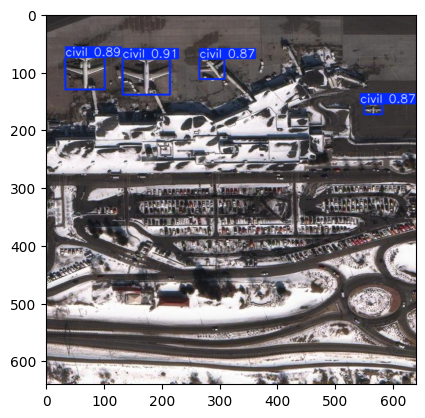

In [ ]:
X_all, y_all, yolo_preds = dataframe_train(pt_yolo, train_set_csv, 'full')

X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.33, stratify=y_all, random_state=22
)

model = XGBClassifier(objective='multi:softprob', num_class=3, eval_metric='mlogloss', random_state=22)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)

# Evaluation
print(f"Evaluation: Baseline")
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))
auc = roc_auc_score(y_val, y_proba, multi_class='ovr', average='macro')
print(f"Macro AUC: {auc:.4f}\n")

joblib.dump(model, "/content/drive/MyDrive/baseline.pkl")


## Baseline (#2)


Evaluation: Baseline
Confusion Matrix:
 [[3105   17   43]
 [  25   55    3]
 [ 168    9  149]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      3165
           1       0.68      0.66      0.67        83
           2       0.76      0.46      0.57       326

    accuracy                           0.93      3574
   macro avg       0.79      0.70      0.73      3574
weighted avg       0.92      0.93      0.92      3574

Macro AUC: 0.9240



['/content/drive/MyDrive/baseline2.pkl']

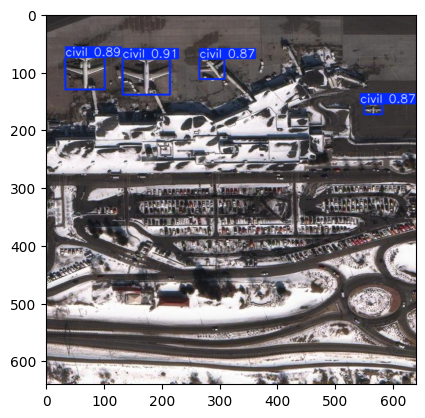

In [ ]:
X_all, y_all, yolo_preds = dataframe_train(pt_yolo, train_set_csv, 'embeddings')

X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.33, stratify=y_all, random_state=22
)

model = XGBClassifier(objective='multi:softprob', num_class=3, eval_metric='mlogloss', random_state=22)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)

print(f"Evaluation: Baseline")
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))
auc = roc_auc_score(y_val, y_proba, multi_class='ovr', average='macro')
print(f"Macro AUC: {auc:.4f}\n")

joblib.dump(model, "/content/drive/MyDrive/baseline2.pkl")


## Baseline (#3)


Evaluation: Baseline
Confusion Matrix:
 [[3087    8   70]
 [  66    2   15]
 [ 166    5  155]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95      3165
           1       0.13      0.02      0.04        83
           2       0.65      0.48      0.55       326

    accuracy                           0.91      3574
   macro avg       0.57      0.49      0.51      3574
weighted avg       0.89      0.91      0.89      3574

Macro AUC: 0.8698



['/content/drive/MyDrive/baseline3.pkl']

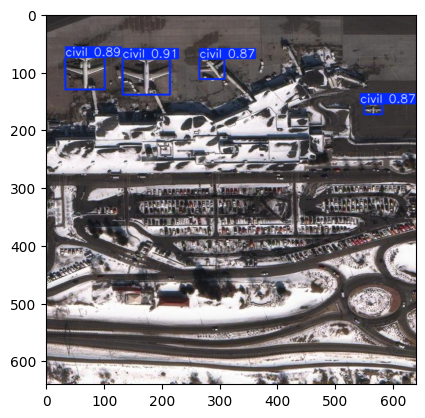

In [ ]:
X_all, y_all, yolo_preds = dataframe_train(pt_yolo, train_set_csv, 'metadata')

X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.33, stratify=y_all, random_state=22
)

model = XGBClassifier(objective='multi:softprob', num_class=3, eval_metric='mlogloss', random_state=22)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)

print(f"Evaluation: Baseline")
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))
auc = roc_auc_score(y_val, y_proba, multi_class='ovr', average='macro')
print(f"Macro AUC: {auc:.4f}\n")

# Save the model
joblib.dump(model, "/content/drive/MyDrive/baseline3.pkl")


## train_and_tune_xgb Function

Function to train and HP tuning of XGB using the created datasets in the previous stage

In [ ]:
def evaluate_and_save_model(model, X_val, y_val, save_path, label="Model"):

    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)

    print(f"\Evaluation: {label}")
    print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
    print("Classification Report:\n", classification_report(y_val, y_pred))
    auc = roc_auc_score(y_val, y_proba, multi_class='ovr', average='macro')
    print(f"Macro AUC: {auc:.4f}\n")

    joblib.dump(model, save_path)
    model.save_model(f"{save_path}.json")

## Train with Optimization 1

In [ ]:

def train_and_tune_xgb(X_all, y_all, scenario_name, save_prefix):
    print(f"{scenario_name}")

    X_train, X_val, y_train, y_val = train_test_split(
        X_all, y_all, test_size=0.33, stratify=y_all, random_state=22
    )

    # Impute before SMOTE
    imputer = SimpleImputer(strategy="mean")
    X_train_imputed = imputer.fit_transform(X_train)

    smote = SMOTE(random_state=22)
    X_train_res, y_train_res = smote.fit_resample(X_train_imputed, y_train)

    # Train SMOTE model
    model = XGBClassifier(objective='multi:softprob', num_class=3, eval_metric='mlogloss', random_state=22)
    model.fit(X_train_res, y_train_res)

    # Impute validation set (since training is done on imputed data)
    X_val_imputed = imputer.transform(X_val)
    evaluate_and_save_model(model, X_val_imputed, y_val, f"{save_prefix}_smote_bas.pkl", f"{scenario_name} SMOTE Baseline")

    # Optuna
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int("n_estimators", 100, 300, step=25),
            'max_depth': trial.suggest_int("max_depth", 3, 12),
            'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            'random_state': 22,
            'objective': 'multi:softprob',
            'num_class': 3,
            'eval_metric': 'mlogloss'
        }

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)
        scores = []

        for train_idx, val_idx in cv.split(X_all, y_all):
            X_train_cv, X_val_cv = X_all[train_idx], X_all[val_idx]
            y_train_cv, y_val_cv = y_all[train_idx], y_all[val_idx]

            # Impute missing values in CV training set before SMOTE
            imputer_cv = SimpleImputer(strategy="mean")
            X_train_cv_imputed = imputer_cv.fit_transform(X_train_cv)

            smote = SMOTE(random_state=22)
            X_train_res, y_train_res = smote.fit_resample(X_train_cv_imputed, y_train_cv)

            model = XGBClassifier(**params)
            model.fit(X_train_res, y_train_res)

            # Impute validation set before scoring
            X_val_cv_imputed = imputer_cv.transform(X_val_cv)
            y_pred = model.predict(X_val_cv_imputed)
            score = f1_score(y_val_cv, y_pred, average='macro')
            scores.append(score)

        return np.mean(scores)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30)

    print(f"Best HPs: {study.best_trial.params}")
    print(f"Best Macro-F1: {study.best_value:.4f}")

    # Final model training on all data
    imputer_final = SimpleImputer(strategy="mean")
    X_all_imputed = imputer_final.fit_transform(X_all)

    smote = SMOTE(random_state=22)
    X_all_res, y_all_res = smote.fit_resample(X_all_imputed, y_all)

    final_model = XGBClassifier(**study.best_trial.params,
                                random_state=22,
                                objective='multi:softprob',
                                num_class=3,
                                eval_metric='mlogloss')
    final_model.fit(X_all_res, y_all_res)
    joblib.dump(final_model, f"{save_prefix}_tuned.pkl")
    final_model.save_model(f"{save_prefix}.json")


### Results




Scenario #1


[I 2025-05-16 16:38:39,179] A new study created in memory with name: no-name-95e19f03-383d-4fda-b7d2-8bffd6494870


\Evaluation: Scenario #1 SMOTE Baseline
Confusion Matrix:
 [[3060   30   75]
 [  15   65    3]
 [ 146   10  170]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      3165
           1       0.62      0.78      0.69        83
           2       0.69      0.52      0.59       326

    accuracy                           0.92      3574
   macro avg       0.75      0.76      0.75      3574
weighted avg       0.92      0.92      0.92      3574

Macro AUC: 0.9148



[I 2025-05-16 16:40:54,898] Trial 0 finished with value: 0.7300416891894057 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.0172352520139489}. Best is trial 0 with value: 0.7300416891894057.
[I 2025-05-16 16:42:04,554] Trial 1 finished with value: 0.7218931349077236 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.02893494782934803}. Best is trial 0 with value: 0.7300416891894057.
[I 2025-05-16 16:43:15,010] Trial 2 finished with value: 0.7527594877820601 and parameters: {'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.2864983332626611}. Best is trial 2 with value: 0.7527594877820601.
[I 2025-05-16 16:43:41,407] Trial 3 finished with value: 0.7404262651702562 and parameters: {'n_estimators': 225, 'max_depth': 3, 'learning_rate': 0.09184027284244273}. Best is trial 2 with value: 0.7527594877820601.
[I 2025-05-16 16:46:44,523] Trial 4 finished with value: 0.7506517502936357 and parameters: {'n_estimators': 250, 'max_depth': 12, 'le

Best HPs: {'n_estimators': 275, 'max_depth': 6, 'learning_rate': 0.20682692712499276}
Best Macro-F1: 0.7548
Scenario #2


[I 2025-05-16 17:32:46,967] A new study created in memory with name: no-name-a4fa8667-c18c-4136-92c3-c67a7915e0d7


\Evaluation: Scenario #2 SMOTE Baseline
Confusion Matrix:
 [[3060   29   76]
 [  15   65    3]
 [ 143   11  172]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      3165
           1       0.62      0.78      0.69        83
           2       0.69      0.53      0.60       326

    accuracy                           0.92      3574
   macro avg       0.75      0.76      0.75      3574
weighted avg       0.92      0.92      0.92      3574

Macro AUC: 0.9111



[I 2025-05-16 17:33:26,755] Trial 0 finished with value: 0.7142159032231354 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.029206857990962908}. Best is trial 0 with value: 0.7142159032231354.
[I 2025-05-16 17:34:12,784] Trial 1 finished with value: 0.7048615694402949 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.018979407287595642}. Best is trial 0 with value: 0.7142159032231354.
[I 2025-05-16 17:42:02,373] Trial 2 finished with value: 0.7244053980927433 and parameters: {'n_estimators': 225, 'max_depth': 12, 'learning_rate': 0.01428317337921777}. Best is trial 2 with value: 0.7244053980927433.
[I 2025-05-16 17:43:04,247] Trial 3 finished with value: 0.7429127148190016 and parameters: {'n_estimators': 225, 'max_depth': 5, 'learning_rate': 0.05422626568570785}. Best is trial 3 with value: 0.7429127148190016.
[I 2025-05-16 17:46:09,553] Trial 4 finished with value: 0.7519899258075455 and parameters: {'n_estimators': 250, 'max_depth': 8,

Best HPs: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.09077161905448762}
Best Macro-F1: 0.7545
Scenario #3


[I 2025-05-16 18:38:50,348] A new study created in memory with name: no-name-31a73c7f-5536-4afa-a661-1d27948318e0


\Evaluation: Scenario #3 SMOTE Baseline
Confusion Matrix:
 [[2576  311  278]
 [  30   31   22]
 [  81   34  211]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.81      0.88      3165
           1       0.08      0.37      0.14        83
           2       0.41      0.65      0.50       326

    accuracy                           0.79      3574
   macro avg       0.48      0.61      0.51      3574
weighted avg       0.89      0.79      0.83      3574

Macro AUC: 0.8280



[I 2025-05-16 18:39:04,470] Trial 0 finished with value: 0.5146349092232241 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.026957906092708823}. Best is trial 0 with value: 0.5146349092232241.
[I 2025-05-16 18:39:07,533] Trial 1 finished with value: 0.4895745633494283 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.010337753650909077}. Best is trial 0 with value: 0.5146349092232241.
[I 2025-05-16 18:39:23,181] Trial 2 finished with value: 0.5147535442258844 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.0152085051323371}. Best is trial 2 with value: 0.5147535442258844.
[I 2025-05-16 18:39:31,582] Trial 3 finished with value: 0.5058566906951923 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.017433049720525378}. Best is trial 2 with value: 0.5147535442258844.
[I 2025-05-16 18:39:46,261] Trial 4 finished with value: 0.5172688459937776 and parameters: {'n_estimators': 225, 'max_depth': 1

Best HPs: {'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.20482426040368754}
Best Macro-F1: 0.5227


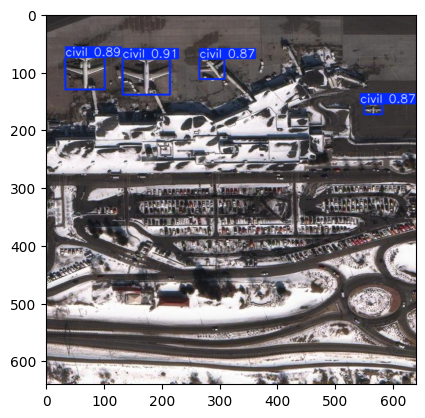

In [ ]:
# Datasets
X_full, y_full, _ = dataframe_train(pt_yolo, train_set_csv, 'full')
X_emb, y_emb, _ = dataframe_train(pt_yolo, train_set_csv, 'embeddings')
X_meta, y_meta, _ = dataframe_train(pt_yolo, train_set_csv, 'metadata')

# Train for all scenarios
train_and_tune_xgb(X_full, y_full, "Scenario #1", "/content/drive/MyDrive/xgb_1")
train_and_tune_xgb(X_emb, y_emb, "Scenario #2", "/content/drive/MyDrive/xgb_2")
train_and_tune_xgb(X_meta, y_meta, "Scenario #3", "/content/drive/MyDrive/xgb_3")

## Train with Optimization 2

In [ ]:
def train_and_tune_xgb(X_all, y_all, scenario_name, save_prefix):
    print(f"{scenario_name}")

    # Split for Baseline and Validation Evaluation
    X_train, X_val, y_train, y_val = train_test_split(
        X_all, y_all, test_size=0.33, stratify=y_all, random_state=22
    )

    # Impute SMOTE
    imputer = SimpleImputer(strategy="mean")
    X_train_imputed = imputer.fit_transform(X_train)

    smote = SMOTE(random_state=22)
    X_train_res, y_train_res = smote.fit_resample(X_train_imputed, y_train)

    # Train SMOTE model
    model = XGBClassifier(objective='multi:softprob', num_class=3, eval_metric='mlogloss', random_state=22)
    model.fit(X_train_res, y_train_res)

    # Impute validation set (since training is done on imputed data)
    X_val_imputed = imputer.transform(X_val)
    evaluate_and_save_model(model, X_val_imputed, y_val, f"{save_prefix}_smote_bas.pkl", f"{scenario_name} SMOTE Baseline")

    # New Optuna
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int("n_estimators", 100, 400, step=50),
            'max_depth': trial.suggest_int("max_depth", 3, 12),
            'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
            'subsample': trial.suggest_float("subsample", 0.6, 1.0),
            'colsample_bytree': trial.suggest_float("colsample_bytree", 0.6, 1.0),
            'min_child_weight': trial.suggest_int("min_child_weight", 1, 10),
            'gamma': trial.suggest_float("gamma", 0.0, 5.0),
            'random_state': 22,
            'objective': 'multi:softprob',
            'num_class': 3,
            'eval_metric': 'mlogloss'
        }

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)
        scores = []

        for train_idx, val_idx in cv.split(X_all, y_all):
            X_train_cv, X_val_cv = X_all[train_idx], X_all[val_idx]
            y_train_cv, y_val_cv = y_all[train_idx], y_all[val_idx]

            # Impute missing values before SMOTE
            imputer_cv = SimpleImputer(strategy="mean")
            X_train_cv_imputed = imputer_cv.fit_transform(X_train_cv)

            smote = SMOTE(random_state=22)
            X_train_res, y_train_res = smote.fit_resample(X_train_cv_imputed, y_train_cv)

            model = XGBClassifier(**params)
            model.fit(X_train_res, y_train_res)

            # Impute validation set
            X_val_cv_imputed = imputer_cv.transform(X_val_cv)
            y_pred = model.predict(X_val_cv_imputed)
            score = f1_score(y_val_cv, y_pred, average='macro')
            scores.append(score)

        return np.mean(scores)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30)

    print(f"Best HPs: {study.best_trial.params}")
    print(f"Best Macro-F1: {study.best_value:.4f}")

    # Final model training on all data
    imputer_final = SimpleImputer(strategy="mean")
    X_all_imputed = imputer_final.fit_transform(X_all)

    smote = SMOTE(random_state=22)
    X_all_res, y_all_res = smote.fit_resample(X_all_imputed, y_all)

    final_model = XGBClassifier(**study.best_trial.params,
                                random_state=22,
                                objective='multi:softprob',
                                num_class=3,
                                eval_metric='mlogloss')
    final_model.fit(X_all_res, y_all_res)
    joblib.dump(final_model, f"{save_prefix}_tuned.pkl")
    final_model.save_model(f"{save_prefix}.json")


### Results




Scenario #1
\Evaluation: Scenario #1 SMOTE Baseline
Confusion Matrix:
 [[3060   30   75]
 [  15   65    3]
 [ 146   10  170]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      3165
           1       0.62      0.78      0.69        83
           2       0.69      0.52      0.59       326

    accuracy                           0.92      3574
   macro avg       0.75      0.76      0.75      3574
weighted avg       0.92      0.92      0.92      3574

Macro AUC: 0.9148



[I 2025-05-16 17:48:20,712] A new study created in memory with name: no-name-71d5dfa2-874d-4d98-bb98-7a56f5b37ad1
[I 2025-05-16 17:48:45,102] Trial 0 finished with value: 0.7454468425979744 and parameters: {'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.25931064914458385, 'subsample': 0.9575771428590297, 'colsample_bytree': 0.6220920371986676, 'min_child_weight': 9, 'gamma': 3.9254872929827807}. Best is trial 0 with value: 0.7454468425979744.
[I 2025-05-16 17:50:32,809] Trial 1 finished with value: 0.7472085117021272 and parameters: {'n_estimators': 150, 'max_depth': 12, 'learning_rate': 0.01952552599690066, 'subsample': 0.979410097374464, 'colsample_bytree': 0.7470412307069833, 'min_child_weight': 9, 'gamma': 4.541854817461047}. Best is trial 1 with value: 0.7472085117021272.
[I 2025-05-16 17:51:06,359] Trial 2 finished with value: 0.6938969756329685 and parameters: {'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.014843127691465148, 'subsample': 0.8079734426196398, '

Best HPs: {'n_estimators': 350, 'max_depth': 10, 'learning_rate': 0.016623705602996957, 'subsample': 0.6006950662429724, 'colsample_bytree': 0.6540031171751515, 'min_child_weight': 6, 'gamma': 1.6002974007732065}
Best Macro-F1: 0.7600


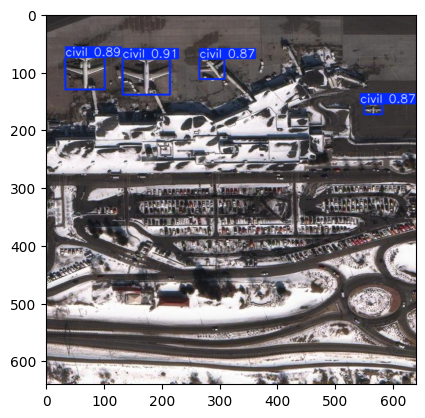

In [ ]:
# Datasets
X_full, y_full, _ = dataframe_train(pt_yolo, train_set_csv, 'full')
X_emb, y_emb, _ = dataframe_train(pt_yolo, train_set_csv, 'embeddings')
X_meta, y_meta, _ = dataframe_train(pt_yolo, train_set_csv, 'metadata')

train_and_tune_xgb(X_full, y_full, "Scenario #1", "/content/drive/MyDrive/xgb_1")



Scenario #2


[I 2025-05-16 19:36:15,602] A new study created in memory with name: no-name-97c52c27-c2dd-4092-b75d-4063008f3ad3


\Evaluation: Scenario #2 SMOTE Baseline
Confusion Matrix:
 [[3060   29   76]
 [  15   65    3]
 [ 143   11  172]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      3165
           1       0.62      0.78      0.69        83
           2       0.69      0.53      0.60       326

    accuracy                           0.92      3574
   macro avg       0.75      0.76      0.75      3574
weighted avg       0.92      0.92      0.92      3574

Macro AUC: 0.9111



[I 2025-05-16 19:36:40,669] Trial 0 finished with value: 0.7437971155966678 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1537140762717824, 'subsample': 0.8462047872026239, 'colsample_bytree': 0.6992903944863207, 'min_child_weight': 1, 'gamma': 3.7144713610811424}. Best is trial 0 with value: 0.7437971155966678.
[I 2025-05-16 19:39:07,457] Trial 1 finished with value: 0.75200244876564 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.021556045941855458, 'subsample': 0.6640001980928288, 'colsample_bytree': 0.88324091492444, 'min_child_weight': 8, 'gamma': 1.3248452536753237}. Best is trial 1 with value: 0.75200244876564.
[I 2025-05-16 19:39:20,902] Trial 2 finished with value: 0.670701913016384 and parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.02329290244899167, 'subsample': 0.6596945009961451, 'colsample_bytree': 0.7077985335230229, 'min_child_weight': 5, 'gamma': 0.9519254702842139}. Best is trial 1 with value: 0

Best HPs: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.029594605083098077, 'subsample': 0.7010397440202003, 'colsample_bytree': 0.63932118877284, 'min_child_weight': 10, 'gamma': 2.0808972256116647}
Best Macro-F1: 0.7590
Scenario #3


[I 2025-05-16 20:32:15,114] A new study created in memory with name: no-name-c4cc8148-23ae-45a0-b7c7-6c2bba578769


\Evaluation: Scenario #3 SMOTE Baseline
Confusion Matrix:
 [[2576  311  278]
 [  30   31   22]
 [  81   34  211]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.81      0.88      3165
           1       0.08      0.37      0.14        83
           2       0.41      0.65      0.50       326

    accuracy                           0.79      3574
   macro avg       0.48      0.61      0.51      3574
weighted avg       0.89      0.79      0.83      3574

Macro AUC: 0.8280



[I 2025-05-16 20:32:17,533] Trial 0 finished with value: 0.5097365627189955 and parameters: {'n_estimators': 350, 'max_depth': 11, 'learning_rate': 0.1952492822422447, 'subsample': 0.8750816215358915, 'colsample_bytree': 0.9840126084723445, 'min_child_weight': 10, 'gamma': 3.464411089576526}. Best is trial 0 with value: 0.5097365627189955.
[I 2025-05-16 20:32:21,168] Trial 1 finished with value: 0.5148153018556664 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.05101610095415506, 'subsample': 0.8006180670789499, 'colsample_bytree': 0.7910940324429522, 'min_child_weight': 1, 'gamma': 1.966915669841041}. Best is trial 1 with value: 0.5148153018556664.
[I 2025-05-16 20:32:26,797] Trial 2 finished with value: 0.5129861673445307 and parameters: {'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.051360125610272284, 'subsample': 0.7322313259383189, 'colsample_bytree': 0.9465323581476884, 'min_child_weight': 9, 'gamma': 2.0827396149190225}. Best is trial 1 with v

Best HPs: {'n_estimators': 400, 'max_depth': 11, 'learning_rate': 0.10554874225570061, 'subsample': 0.8244690243596938, 'colsample_bytree': 0.8289582919104975, 'min_child_weight': 5, 'gamma': 0.8551966135435828}
Best Macro-F1: 0.5218


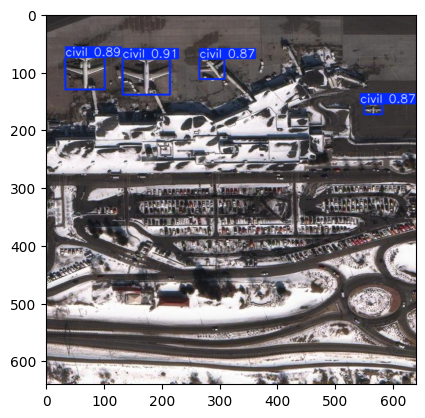

In [ ]:
X_emb, y_emb, _ = dataframe_train(pt_yolo, train_set_csv, 'embeddings')
X_meta, y_meta, _ = dataframe_train(pt_yolo, train_set_csv, 'metadata')

train_and_tune_xgb(X_emb, y_emb, "Scenario #2", "/content/drive/MyDrive/xgb_2")
train_and_tune_xgb(X_meta, y_meta, "Scenario #3", "/content/drive/MyDrive/xgb_3")

# **>>> TESTING PHASE**

Two functions were introduced to simplify the testing phase, as was done in the training. The first, dataframe_test, is to create datasets from the test values. The second, evaluate_model, is to evaluate each model for each scenario and to collect these metrics for the analysis.

**Best of Scenario #1** >> from Optimization 2
> Best HPs: {'n_estimators': 350, 'max_depth': 10, 'learning_rate': 0.016623705602996957, 'subsample': 0.6006950662429724, 'colsample_bytree': 0.6540031171751515, 'min_child_weight': 6, 'gamma': 1.6002974007732065}
>> Best Macro-F1: 0.7600

Model Name: xgb_1_tuned_2.pkl

**Best of Scenario #2** >> from Optimization 2
> Best HPs: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.029594605083098077, 'subsample': 0.7010397440202003, 'colsample_bytree': 0.63932118877284, 'min_child_weight': 10, 'gamma': 2.0808972256116647}
>> Best Macro-F1: 0.7590

Model Name: xgb_2_tuned_2.pkl

**Best of Scenario #3** >> from Optimization 1
> Best HPs: {'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.20482426040368754}
>> Best Macro-F1: 0.5227

Model Name: xgb_3_tuned_1.pkl


In [21]:
pt_yolo = "/content/drive/MyDrive/final_train/weights/best.pt"
test_set_csv = "/content/drive/MyDrive/YOLO_roboflow_/test/gt_test.csv" # Test sets GT to use y-test values

## dataframe_test Function

To create test dataframes to test XGB on them, so that it can make predictions and then they will be compared with GT

In [22]:
def dataframe_test(yolo_model, test_set_csv, data_type):
  model = YOLO(yolo_model)

  model.model._predict_once = MethodType(_predict_once, model.model)

  _ = model("/content/drive/MyDrive/YOLO_roboflow_/test/images/108_10400100457A8A00_tile_2.png", save=False, embed=[16, 19, 22, 23])

  imgs = [cv2.imread("/content/drive/MyDrive/YOLO_roboflow_/test/images/108_10400100457A8A00_tile_2.png")]
  prepped = model.predictor.preprocess(imgs)
  result = model.predictor.inference(prepped)

  nc = model.model.yaml['nc']
  output, idxs = non_max_suppression(result[-1][0], nc=nc, in_place=False)

  obj_feats = get_object_features(result[:3], idxs)

  # Image Inferencedf_full_test
  image_i = 0  # index of the image in batch
  output[image_i][:, :4] = scale_boxes(prepped.shape[2:], output[image_i][:, :4], imgs[image_i].shape)
  result = Results(imgs[image_i], path="", names=model.predictor.model.names, boxes=output[image_i][:, :6])
  plt.imshow(result.plot()[..., ::-1])

  # All data to create the df
  image_paths = sorted(glob("/content/drive/MyDrive/YOLO_roboflow_/test/images/*.png"))

  all_rows = []
  for img_path in image_paths:
      image_data = extract_image_data(model, img_path)
      all_rows.extend(image_data)

  flat_rows = []
  for row in all_rows:
      flat_row = {
          "image": row["image"],
          "class": row["class"],
          "confidence": row["confidence"],
      }
      flat_row.update({f"emb_{i}": val for i, val in enumerate(row["embedding"])})
      flat_row.update({f"meta_{i}": val for i, val in enumerate(row["features"])})
      flat_rows.append(flat_row)

  xgb_data_test = pd.DataFrame(flat_rows)


# For clear names
  xgb_data_test.rename(columns={
    "meta_0": "width_m",
    "meta_1": "height_m",
    "meta_2": "area_m",
    "meta_3": "perimeter_m",
    "meta_4": "hull_area_m",
    "meta_5": "compactness_m",
    "meta_6": "wingspan_class",
}, inplace=True)

  # Label encoder from train
  le = joblib.load("/content/drive/MyDrive/label_encoder.pkl")
  xgb_data_test['wingspan_class'] = le.transform(xgb_data_test['wingspan_class'])  # Transform test data labels

  yolo_preds = xgb_data_test["class"]
  y_test = pd.read_csv(test_set_csv)

  # To add YOLO's extra predictions and/or the ones which it couldn't see
  xgb_data_test = pd.merge(xgb_data_test, y_test, on='image', how='outer')
  xgb_data_test['class_id'] = xgb_data_test['class_id'].fillna(2).astype(int)
  y_test =  xgb_data_test['class_id'].values # It is too compare XGB and YOLO performance later. Not used for any other purpose
  xgb_data_test.to_csv("xgb_data_test_1.csv", index=False)

  # Drop the unnecessary columns of YOLO
  xgb_data_test_with_yolopred_gt = xgb_data_test.copy() # ORIGINAL SET WITH YOLO PRED AND GT
  xgb_data_test_with_yolopred_gt.to_csv(f"yolopred_gt_{data_type}.csv", index=False)
  xgb_data_test = xgb_data_test.drop(columns=["class_id"])
  xgb_data_test = xgb_data_test.drop(columns=["class", "image"])
  xgb_data_test.to_csv("xgb_data_test_2.csv", index=False)

  # Scaler from Training
  scaler = joblib.load("/content/drive/MyDrive/scaler.pkl")
  columns_to_scale = xgb_data_test.columns[0:263]
  xgb_data_test[columns_to_scale] = scaler.transform(xgb_data_test[columns_to_scale])

  if data_type == "full":
    X_test = xgb_data_test.values
    xgb_data_test.to_csv("xgb_data_test_full.csv", index=False)
  elif data_type == "embeddings":
    # Drop columns
    embeddings_df = xgb_data_test.drop(xgb_data_test.columns[257:264], axis=1)
    X_test = embeddings_df.values
    embeddings_df.to_csv("xgb_data_test_embeddings.csv", index=False)
  elif data_type == "metadata":
    selected_columns = list(xgb_data_test.columns[257:264]) + [xgb_data_test.columns[0]]
    metadata_df = xgb_data_test[selected_columns]
    X_test = metadata_df.values
    metadata_df.to_csv("xgb_data_test_metadata.csv", index=False)
  else:
    print('error')

  return X_test, y_test, yolo_preds

# Apply to Create 3 Scenarios

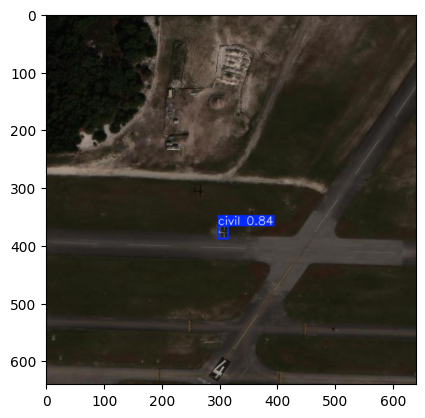

In [23]:
X_test, y_test, yolo_preds = dataframe_test(pt_yolo, test_set_csv, "full")

In [24]:
yolo_and_gt = pd.read_csv("yolopred_gt_full.csv")

In [25]:
yolo_and_gt

,image,class,confidence,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,...,emb_254,emb_255,width_m,height_m,area_m,perimeter_m,hull_area_m,compactness_m,wingspan_class,class_id
0,105_104001003108D900_tile_1_1,0.0,0.829615,-0.272978,0.693262,1.213782,0.507367,0.361367,0.390327,-0.272899,...,-0.200984,-0.204095,11.229089,3.974844,44.633882,30.407867,148.779608,0.494560,0.0,0
1,105_104001003108D900_tile_2_1,0.0,0.843094,-0.273863,0.434097,0.815627,0.184825,0.655021,0.704275,-0.173952,...,-0.116778,-0.065399,9.660919,6.250589,60.386435,31.823016,201.288117,0.400364,0.0,0
2,105_104001003108D900_tile_2_2,0.0,0.835433,-0.273487,-0.275343,0.767686,0.460540,1.500953,0.428252,-0.112447,...,-0.274835,-0.227155,9.375494,6.273017,58.812637,31.297023,196.042123,0.397600,0.0,0
3,105_104001003108D900_tile_2_3,0.0,0.834693,-0.278146,-0.221933,1.085032,-0.115864,0.871668,0.745240,-0.172805,...,-0.113441,-0.121743,10.668933,6.471414,69.043085,34.280695,230.143617,0.406341,0.0,0
4,105_104001003108D900_tile_2_4,0.0,0.798266,-0.278212,0.023564,0.497129,0.435159,2.480454,0.374992,-0.276475,...,1.813435,-0.059396,8.664990,4.184271,36.256669,25.698523,120.855565,0.434850,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3678,96_104001003C8C7800_tile_7_2,0.0,0.745913,-0.276480,0.354532,0.334777,0.518788,0.308521,0.282931,-0.277362,...,-0.232934,-0.269533,15.386481,7.197950,110.751124,45.168862,369.170415,0.439786,1.0,0
3679,96_104001003C8C7800_tile_7_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3680,96_104001003C8C7800_tile_8_1,0.0,0.835741,-0.114544,0.666156,1.074877,-0.263916,-0.087007,-0.249931,-0.174357,...,-0.142458,-0.169774,27.784551,14.898674,413.952966,85.366450,1379.843219,0.420276,2.0,0
3681,96_104001003C8C7800_tile_9_1,0.0,0.778655,0.013920,0.371002,0.547206,0.167611,1.074366,0.802835,-0.274604,...,-0.127795,-0.079612,11.438342,4.515601,51.650985,31.907886,172.169950,0.470575,0.0,0


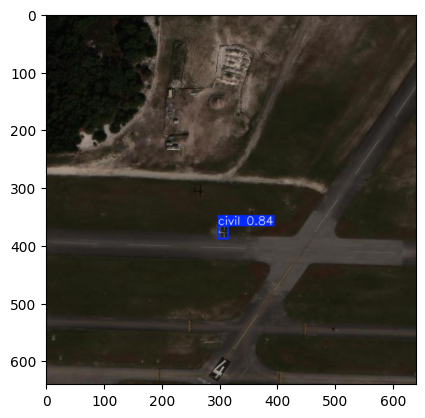

In [26]:
X_test2, y_test2, yolo_preds_2 = dataframe_test(pt_yolo, test_set_csv, "embeddings")

In [27]:
yolo_and_gt_embeddings = pd.read_csv("yolopred_gt_embeddings.csv")
yolo_and_gt_embeddings

,image,class,confidence,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,...,emb_254,emb_255,width_m,height_m,area_m,perimeter_m,hull_area_m,compactness_m,wingspan_class,class_id
0,105_104001003108D900_tile_1_1,0.0,0.829615,-0.272978,0.693262,1.213782,0.507367,0.361367,0.390327,-0.272899,...,-0.200984,-0.204095,11.229089,3.974844,44.633882,30.407867,148.779608,0.494560,0.0,0
1,105_104001003108D900_tile_2_1,0.0,0.843094,-0.273863,0.434097,0.815627,0.184825,0.655021,0.704275,-0.173952,...,-0.116778,-0.065399,9.660919,6.250589,60.386435,31.823016,201.288117,0.400364,0.0,0
2,105_104001003108D900_tile_2_2,0.0,0.835433,-0.273487,-0.275343,0.767686,0.460540,1.500953,0.428252,-0.112447,...,-0.274835,-0.227155,9.375494,6.273017,58.812637,31.297023,196.042123,0.397600,0.0,0
3,105_104001003108D900_tile_2_3,0.0,0.834693,-0.278146,-0.221933,1.085032,-0.115864,0.871668,0.745240,-0.172805,...,-0.113441,-0.121743,10.668933,6.471414,69.043085,34.280695,230.143617,0.406341,0.0,0
4,105_104001003108D900_tile_2_4,0.0,0.798266,-0.278212,0.023564,0.497129,0.435159,2.480454,0.374992,-0.276475,...,1.813435,-0.059396,8.664990,4.184271,36.256669,25.698523,120.855565,0.434850,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3678,96_104001003C8C7800_tile_7_2,0.0,0.745913,-0.276480,0.354532,0.334777,0.518788,0.308521,0.282931,-0.277362,...,-0.232934,-0.269533,15.386481,7.197950,110.751124,45.168862,369.170415,0.439786,1.0,0
3679,96_104001003C8C7800_tile_7_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3680,96_104001003C8C7800_tile_8_1,0.0,0.835741,-0.114544,0.666156,1.074877,-0.263916,-0.087007,-0.249931,-0.174357,...,-0.142458,-0.169774,27.784551,14.898674,413.952966,85.366450,1379.843219,0.420276,2.0,0
3681,96_104001003C8C7800_tile_9_1,0.0,0.778655,0.013920,0.371002,0.547206,0.167611,1.074366,0.802835,-0.274604,...,-0.127795,-0.079612,11.438342,4.515601,51.650985,31.907886,172.169950,0.470575,0.0,0


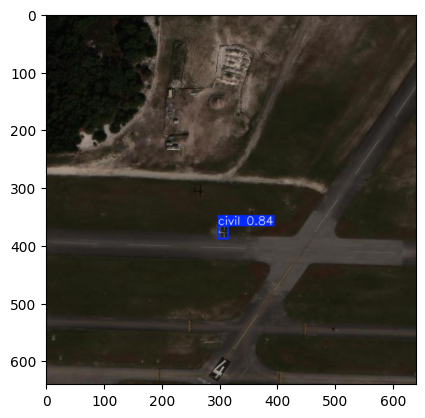

In [28]:
X_test3, y_test3, yolo_preds_3 = dataframe_test(pt_yolo, test_set_csv, "metadata")

In [29]:
yolo_and_gt_metadata = pd.read_csv("yolopred_gt_metadata.csv")
yolo_and_gt_metadata

,image,class,confidence,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,...,emb_254,emb_255,width_m,height_m,area_m,perimeter_m,hull_area_m,compactness_m,wingspan_class,class_id
0,105_104001003108D900_tile_1_1,0.0,0.829615,-0.272978,0.693262,1.213782,0.507367,0.361367,0.390327,-0.272899,...,-0.200984,-0.204095,11.229089,3.974844,44.633882,30.407867,148.779608,0.494560,0.0,0
1,105_104001003108D900_tile_2_1,0.0,0.843094,-0.273863,0.434097,0.815627,0.184825,0.655021,0.704275,-0.173952,...,-0.116778,-0.065399,9.660919,6.250589,60.386435,31.823016,201.288117,0.400364,0.0,0
2,105_104001003108D900_tile_2_2,0.0,0.835433,-0.273487,-0.275343,0.767686,0.460540,1.500953,0.428252,-0.112447,...,-0.274835,-0.227155,9.375494,6.273017,58.812637,31.297023,196.042123,0.397600,0.0,0
3,105_104001003108D900_tile_2_3,0.0,0.834693,-0.278146,-0.221933,1.085032,-0.115864,0.871668,0.745240,-0.172805,...,-0.113441,-0.121743,10.668933,6.471414,69.043085,34.280695,230.143617,0.406341,0.0,0
4,105_104001003108D900_tile_2_4,0.0,0.798266,-0.278212,0.023564,0.497129,0.435159,2.480454,0.374992,-0.276475,...,1.813435,-0.059396,8.664990,4.184271,36.256669,25.698523,120.855565,0.434850,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3678,96_104001003C8C7800_tile_7_2,0.0,0.745913,-0.276480,0.354532,0.334777,0.518788,0.308521,0.282931,-0.277362,...,-0.232934,-0.269533,15.386481,7.197950,110.751124,45.168862,369.170415,0.439786,1.0,0
3679,96_104001003C8C7800_tile_7_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3680,96_104001003C8C7800_tile_8_1,0.0,0.835741,-0.114544,0.666156,1.074877,-0.263916,-0.087007,-0.249931,-0.174357,...,-0.142458,-0.169774,27.784551,14.898674,413.952966,85.366450,1379.843219,0.420276,2.0,0
3681,96_104001003C8C7800_tile_9_1,0.0,0.778655,0.013920,0.371002,0.547206,0.167611,1.074366,0.802835,-0.274604,...,-0.127795,-0.079612,11.438342,4.515601,51.650985,31.907886,172.169950,0.470575,0.0,0


# **>>> EVALUATION OF XGB MODELS &  XGB on YOLO**

# Evaluation Function

In [56]:
def evaluate_model(model_path, X_test, y_test, yolo_preds, scenario_name, model_name, yolo_gt, yolo_error=2, verbose=True):
    model = joblib.load(model_path) #Saved models that was mentioned before

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    # yolo_and_gt = pd.read_csv(yolo_gt) # ORIGINAL SET WITH YOLO PRED AND GT
    yolo_and_gt["xgb_pred"] = y_pred # ORIGINAL SET WITH YOLO PRED, GT AND XGB PRED
    all_and_gt = yolo_and_gt

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
    f1_macro_all = f1_score(y_test, y_pred, labels=[0, 1, 2], average='macro')
    f1_macro_no_bg = f1_score(y_test, y_pred, labels=[0, 1], average='macro')

    print(report_dict)
    print("Macro F1 (with class2):", round(f1_macro_all, 4))
    print("Macro F1 (no class2):", round(f1_macro_no_bg, 4))

    show_cm = True
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix: {scenario_name}, {model_name}')
    plt.show()

    # YOLO predictions vs GT
    yolo_error = all_and_gt[all_and_gt["class"] != all_and_gt["class_id"]]
    yolo_error = len(yolo_error)
    # print(yolo_error) # yolo errors

    # XGB predictions vs GT
    xgb_error = all_and_gt[all_and_gt["xgb_pred"] != all_and_gt["class_id"]]
    xgb_error = len(xgb_error)
    # print(xgb_error) # xgb errors

    yolo_xgb_both_error = all_and_gt[all_and_gt["xgb_pred"] == all_and_gt["class"]]
    yolo_xgb_both_error = yolo_xgb_both_error[yolo_xgb_both_error["class_id"] != yolo_xgb_both_error["xgb_pred"]]
    yolo_xgb_both_error = (len(yolo_xgb_both_error))
    # print(yolo_xgb_both_error) # both error

    fixed_by_xgb = all_and_gt[
        (all_and_gt["class"] != all_and_gt["class_id"]) &  # YOLO was wrong
        (all_and_gt["xgb_pred"] == all_and_gt["class_id"])  # XGB was correct
    ]
    fixed_by_xgb = (len(fixed_by_xgb))  # Number of YOLO errors corrected by XGB

    worsened_by_xgb = all_and_gt[
    (all_and_gt["class"] == all_and_gt["class_id"]) &  # YOLO was correct
    (all_and_gt["xgb_pred"] != all_and_gt["class_id"])  # XGB was wrong
]
    worsened_by_xgb = (len(worsened_by_xgb))  # XGB worsened the YOLO prediction


    # All results
    summary = {
        'Scenario': scenario_name,
        'Model': model_name,
        'Macro F1': round(f1_macro_all, 4),
        'Macro F1 (no Background)': round(f1_macro_no_bg, 4),
        'Macro AUC': round(auc, 4),
        'YOLO mistakes': yolo_error,
        'Fixed by XGB': fixed_by_xgb,
        'Made worse by XGB': worsened_by_xgb,
        'Both wrong but differently': yolo_xgb_both_error,
        'Total mistakes after XGB applied': xgb_error

    }

    return summary


# END RESULTS

In [59]:
yolo_and_gt = pd.read_csv("yolopred_gt_full.csv")
yolo_and_gt_embeddings = pd.read_csv("yolopred_gt_embeddings.csv")
yolo_and_gt_metadata = pd.read_csv("yolopred_gt_metadata.csv")

{'0': {'precision': 0.9208308248043348, 'recall': 0.9735837046467218, 'f1-score': 0.9464727722772277, 'support': 3142.0}, '1': {'precision': 0.7578947368421053, 'recall': 0.42857142857142855, 'f1-score': 0.5475285171102662, 'support': 168.0}, '2': {'precision': 0.6428571428571429, 'recall': 0.4584450402144772, 'f1-score': 0.5352112676056338, 'support': 373.0}, 'accuracy': 0.896551724137931, 'macro avg': {'precision': 0.7738609015011942, 'recall': 0.6202000578108758, 'f1-score': 0.6764041856643758, 'support': 3683.0}, 'weighted avg': {'precision': 0.8852463973962551, 'recall': 0.896551724137931, 'f1-score': 0.8866239598659993, 'support': 3683.0}}
Macro F1 (with class2): 0.6764
Macro F1 (no class2): 0.747


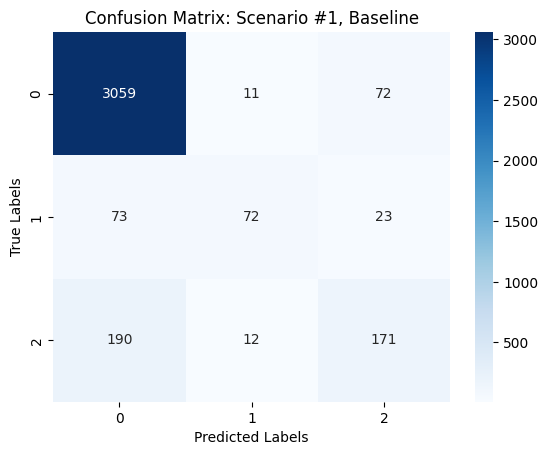

{'0': {'precision': 0.9320508842693143, 'recall': 0.9560789306174411, 'f1-score': 0.9439120188531029, 'support': 3142.0}, '1': {'precision': 0.7766990291262136, 'recall': 0.47619047619047616, 'f1-score': 0.5904059040590406, 'support': 168.0}, '2': {'precision': 0.5742296918767507, 'recall': 0.5495978552278821, 'f1-score': 0.5616438356164384, 'support': 373.0}, 'accuracy': 0.8930219929405376, 'macro avg': {'precision': 0.7609932017574262, 'recall': 0.6606224206785999, 'f1-score': 0.6986539195095274, 'support': 3683.0}, 'weighted avg': {'precision': 0.8887257644141778, 'recall': 0.8930219929405376, 'f1-score': 0.889072198154575, 'support': 3683.0}}
Macro F1 (with class2): 0.6987
Macro F1 (no class2): 0.7672


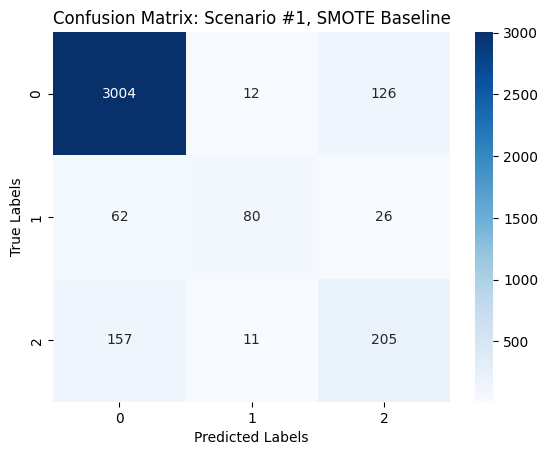

{'0': {'precision': 0.939671509791535, 'recall': 0.9468491406747295, 'f1-score': 0.9432466708941027, 'support': 3142.0}, '1': {'precision': 0.7265625, 'recall': 0.5535714285714286, 'f1-score': 0.6283783783783784, 'support': 168.0}, '2': {'precision': 0.5578406169665809, 'recall': 0.5817694369973191, 'f1-score': 0.5695538057742782, 'support': 373.0}, 'accuracy': 0.8919359218028781, 'macro avg': {'precision': 0.741358208919372, 'recall': 0.6940633354144924, 'f1-score': 0.7137262850155865, 'support': 3683.0}, 'weighted avg': {'precision': 0.891280188404436, 'recall': 0.8919359218028781, 'f1-score': 0.8910377890498627, 'support': 3683.0}}
Macro F1 (with class2): 0.7137
Macro F1 (no class2): 0.7858


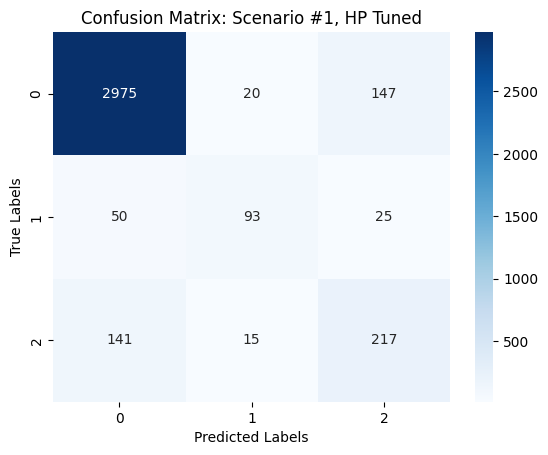

In [60]:
summaries = []

# Scenario 1
summaries.append(evaluate_model("/content/drive/MyDrive/baseline.pkl", X_test, y_test, yolo_preds, "Scenario #1",  "Baseline", yolo_and_gt))
summaries.append(evaluate_model("/content/drive/MyDrive/files/xgb_1_smote_bas.pkl", X_test, y_test, yolo_preds, "Scenario #1", "SMOTE Baseline", yolo_and_gt))
summaries.append(evaluate_model("/content/drive/MyDrive/files/xgb_1_tuned_2.pkl", X_test, y_test, yolo_preds, "Scenario #1", "HP Tuned", yolo_and_gt))

{'0': {'precision': 0.9215686274509803, 'recall': 0.972310630171865, 'f1-score': 0.94625987300604, 'support': 3142.0}, '1': {'precision': 0.7717391304347826, 'recall': 0.4226190476190476, 'f1-score': 0.5461538461538461, 'support': 168.0}, '2': {'precision': 0.6340579710144928, 'recall': 0.4691689008042895, 'f1-score': 0.539291217257319, 'support': 373.0}, 'accuracy': 0.8962802063535161, 'macro avg': {'precision': 0.7757885763000852, 'recall': 0.6213661928650674, 'f1-score': 0.677234978805735, 'support': 3683.0}, 'weighted avg': {'precision': 0.8856161891263725, 'recall': 0.8962802063535161, 'f1-score': 0.8867928295345652, 'support': 3683.0}}
Macro F1 (with class2): 0.6772
Macro F1 (no class2): 0.7462


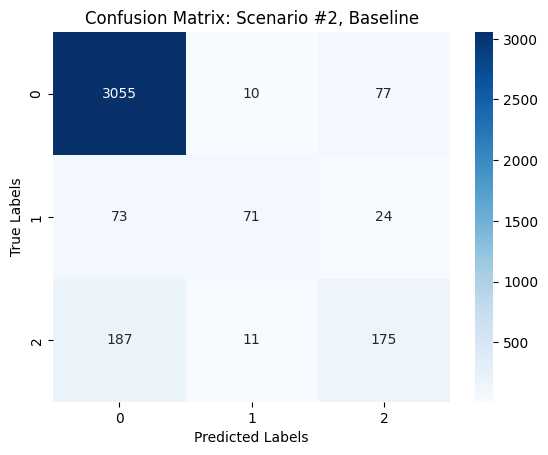

{'0': {'precision': 0.9330426658361881, 'recall': 0.9535327816677276, 'f1-score': 0.9431764520698882, 'support': 3142.0}, '1': {'precision': 0.7606837606837606, 'recall': 0.5297619047619048, 'f1-score': 0.624561403508772, 'support': 168.0}, '2': {'precision': 0.5859154929577465, 'recall': 0.5576407506702413, 'f1-score': 0.5714285714285714, 'support': 373.0}, 'accuracy': 0.8941080640781971, 'macro avg': {'precision': 0.7598806398258984, 'recall': 0.6803118123666246, 'f1-score': 0.7130554756690772, 'support': 3683.0}, 'weighted avg': {'precision': 0.890024818551565, 'recall': 0.8941080640781971, 'f1-score': 0.8909936425022861, 'support': 3683.0}}
Macro F1 (with class2): 0.7131
Macro F1 (no class2): 0.7839


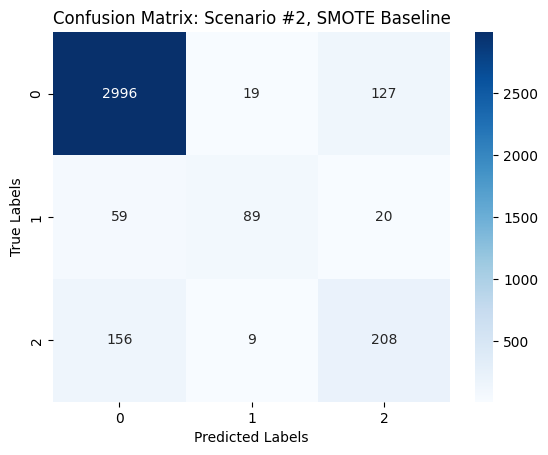

{'0': {'precision': 0.9402466013278533, 'recall': 0.9465308720560153, 'f1-score': 0.9433782712133227, 'support': 3142.0}, '1': {'precision': 0.7265625, 'recall': 0.5535714285714286, 'f1-score': 0.6283783783783784, 'support': 168.0}, '2': {'precision': 0.5612244897959183, 'recall': 0.5898123324396782, 'f1-score': 0.5751633986928104, 'support': 373.0}, 'accuracy': 0.8924789573717078, 'macro avg': {'precision': 0.7426778637079239, 'recall': 0.696638211022374, 'f1-score': 0.7156400160948371, 'support': 3683.0}, 'weighted avg': {'precision': 0.8921135096567996, 'recall': 0.8924789573717078, 'f1-score': 0.8917181763324046, 'support': 3683.0}}
Macro F1 (with class2): 0.7156
Macro F1 (no class2): 0.7859


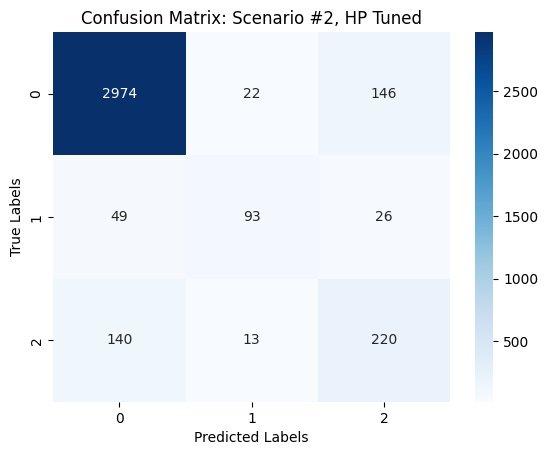

In [61]:
# Scenario 2
summaries.append(evaluate_model("/content/drive/MyDrive/baseline2.pkl", X_test2, y_test2, yolo_preds_2, "Scenario #2", "Baseline", yolo_and_gt_embeddings))
summaries.append(evaluate_model("/content/drive/MyDrive/files/xgb_2_smote_bas.pkl", X_test2, y_test2, yolo_preds_2, "Scenario #2", "SMOTE Baseline", yolo_and_gt_embeddings))
summaries.append(evaluate_model("/content/drive/MyDrive/files/xgb_2_tuned_2.pkl", X_test2, y_test2, yolo_preds_2, "Scenario #2", "HP Tuned", yolo_and_gt_embeddings))

{'0': {'precision': 0.9061941631923764, 'recall': 0.9684914067472947, 'f1-score': 0.9363076923076923, 'support': 3142.0}, '1': {'precision': 0.42105263157894735, 'recall': 0.047619047619047616, 'f1-score': 0.0855614973262032, 'support': 168.0}, '2': {'precision': 0.5686274509803921, 'recall': 0.46648793565683644, 'f1-score': 0.5125184094256259, 'support': 373.0}, 'accuracy': 0.8756448547379854, 'macro avg': {'precision': 0.6319580819172387, 'recall': 0.49419946334105963, 'f1-score': 0.5114625330198405, 'support': 3683.0}, 'weighted avg': {'precision': 0.849876986715014, 'recall': 0.8756448547379854, 'f1-score': 0.8545811749924871, 'support': 3683.0}}
Macro F1 (with class2): 0.5115
Macro F1 (no class2): 0.5109


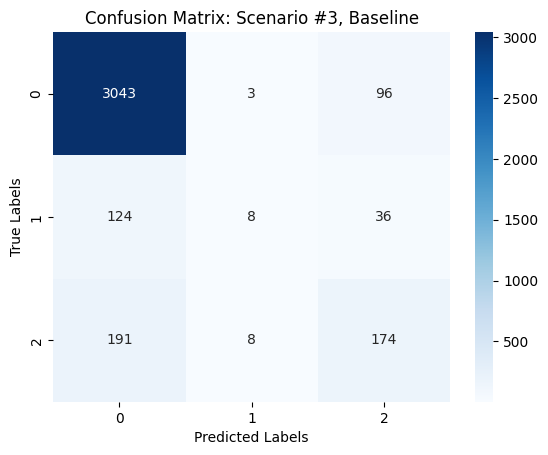

{'0': {'precision': 0.9331128261668504, 'recall': 0.8080840229153405, 'f1-score': 0.8661095002558418, 'support': 3142.0}, '1': {'precision': 0.09158415841584158, 'recall': 0.22023809523809523, 'f1-score': 0.12937062937062938, 'support': 168.0}, '2': {'precision': 0.3960573476702509, 'recall': 0.5924932975871313, 'f1-score': 0.4747583243823845, 'support': 373.0}, 'accuracy': 0.759435243008417, 'macro avg': {'precision': 0.47358477741764765, 'recall': 0.5402718052468557, 'f1-score': 0.49007948466961854, 'support': 3683.0}, 'weighted avg': {'precision': 0.8403356038857207, 'recall': 0.759435243008417, 'f1-score': 0.7928686316950175, 'support': 3683.0}}
Macro F1 (with class2): 0.4901
Macro F1 (no class2): 0.4977


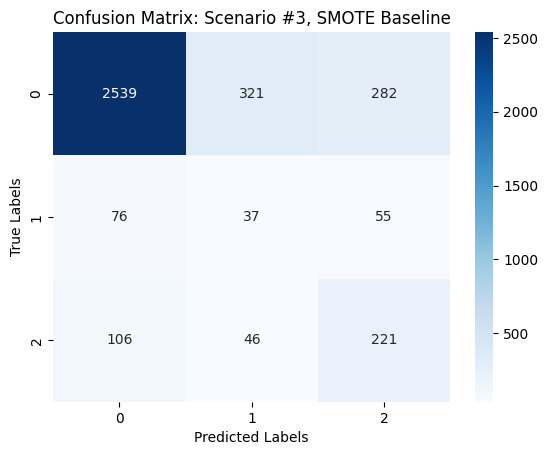

{'0': {'precision': 0.9258595988538681, 'recall': 0.8227243793761935, 'f1-score': 0.8712504213009774, 'support': 3142.0}, '1': {'precision': 0.11515151515151516, 'recall': 0.2261904761904762, 'f1-score': 0.15261044176706828, 'support': 168.0}, '2': {'precision': 0.3868092691622103, 'recall': 0.5817694369973191, 'f1-score': 0.46466809421841543, 'support': 373.0}, 'accuracy': 0.7711105077382568, 'macro avg': {'precision': 0.4759401277225312, 'recall': 0.5435614308546629, 'f1-score': 0.49617631909548704, 'support': 3683.0}, 'weighted avg': {'precision': 0.8342862263214262, 'recall': 0.7711105077382568, 'f1-score': 0.797292581343472, 'support': 3683.0}}
Macro F1 (with class2): 0.4962
Macro F1 (no class2): 0.5119


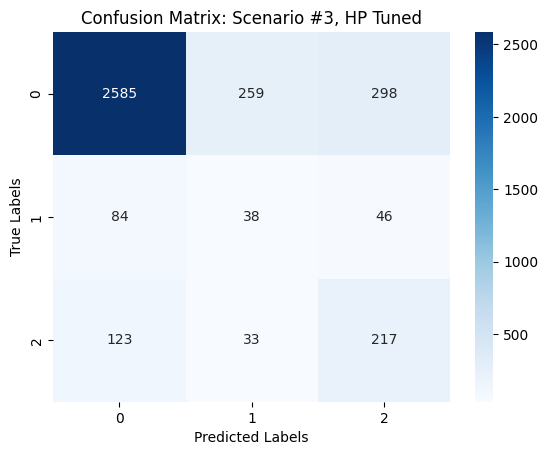

In [62]:
# Scenario 3
summaries.append(evaluate_model("/content/drive/MyDrive/baseline3.pkl", X_test3, y_test3, yolo_preds_3, "Scenario #3", "Baseline", yolo_and_gt_metadata))
summaries.append(evaluate_model("/content/drive/MyDrive/files/xgb_3_smote_bas.pkl", X_test3, y_test3, yolo_preds_3, "Scenario #3", "SMOTE Baseline", yolo_and_gt_metadata))
summaries.append(evaluate_model("/content/drive/MyDrive/files/xgb_3_tuned.pkl", X_test3, y_test3, yolo_preds_3, "Scenario #3", "HP Tuned", yolo_and_gt_metadata))

In [63]:
summary_df = pd.DataFrame(summaries)
summary_df

,Scenario,Model,Macro F1,Macro F1 (no Background),Macro AUC,YOLO mistakes,Fixed by XGB,Made worse by XGB,Both wrong but differently,Total mistakes after XGB applied
0,Scenario #1,Baseline,0.6764,0.7470,0.8983,527,251,105,236,381
1,Scenario #1,SMOTE Baseline,0.6987,0.7672,0.8976,527,282,149,201,394
2,Scenario #1,HP Tuned,0.7137,0.7858,0.9037,527,290,161,192,398
3,Scenario #2,Baseline,0.6772,0.7462,0.8991,527,255,110,230,382
4,Scenario #2,SMOTE Baseline,0.7131,0.7839,0.8914,527,284,147,203,390
5,Scenario #2,HP Tuned,0.7156,0.7859,0.9012,527,293,162,189,396
6,Scenario #3,Baseline,0.5115,0.5109,0.8269,527,258,189,207,458
7,Scenario #3,SMOTE Baseline,0.4901,0.4977,0.7384,527,305,664,126,886
8,Scenario #3,HP Tuned,0.4962,0.5119,0.7488,527,298,614,142,843


# **>>> FEATURE ANALYSIS**

# SHAPLEY

## Scenario1 Baseline

100%|===================| 10997/11049 [02:29<00:00]       

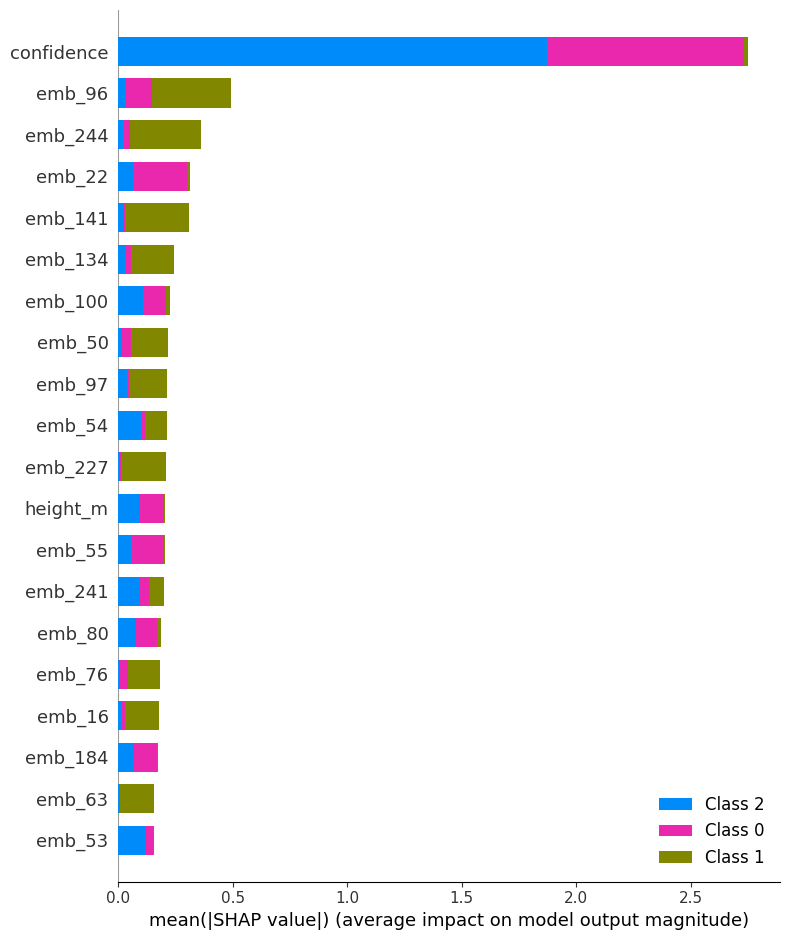

In [46]:
X_train = pd.read_csv("/content/drive/MyDrive/ultralytics/xgb_data_train.csv")
y_train = pd.read_csv("/content/drive/MyDrive/ultralytics/y_train.csv")
X_test = pd.read_csv("/content/drive/MyDrive/ultralytics/xgb_data_test_full.csv")
model = joblib.load("/content/drive/MyDrive/baseline.pkl")

explainer = shap.TreeExplainer(model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

##  Scenario1 HP Tuned

100%|===================| 11044/11049 [20:58<00:00]       

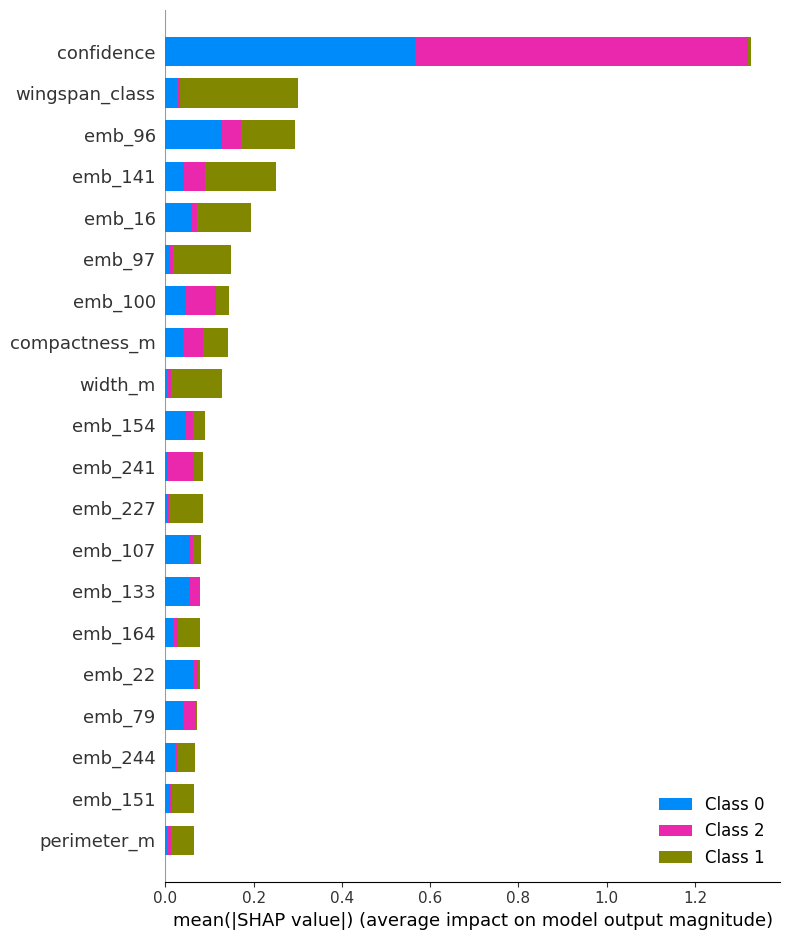

In [47]:
model = joblib.load("/content/drive/MyDrive/files/xgb_1_tuned_2.pkl")

explainer = shap.TreeExplainer(model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)